use_cuda
1
[INFO]:Building the style transfer model...
[INFO]:Optimizing...
[RUN]: [50]
[Style Loss]: 8.193624 [Content Loss]: 3.258350



d:\Anaconda3\lib\site-packages\ipykernel\__main__.py:164: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[RUN]: [100]
[Style Loss]: 3.399277 [Content Loss]: 2.205480

[RUN]: [150]
[Style Loss]: 1.646805 [Content Loss]: 2.014344

[RUN]: [200]
[Style Loss]: 0.649033 [Content Loss]: 2.082869

[RUN]: [250]
[Style Loss]: 0.465811 [Content Loss]: 1.898731

[RUN]: [300]
[Style Loss]: 0.445368 [Content Loss]: 1.809600

[RUN]: [350]
[Style Loss]: 0.463533 [Content Loss]: 1.745905

[RUN]: [400]
[Style Loss]: 0.406535 [Content Loss]: 1.749085

2


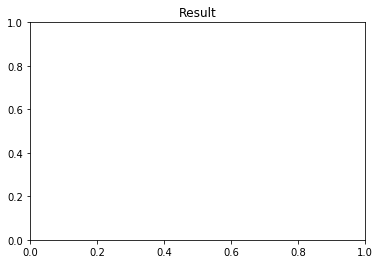

In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy


use_cuda = torch.cuda.is_available()
print('use_cuda')

dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor


# 载入图像
imgsize = 256 if use_cuda else 128
loader = transforms.Compose([
    transforms.Resize(imgsize),
    transforms.ToTensor()
])
def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # 添加假的batch维来满足网络输入
    image = image.unsqueeze(0)
    return image


# 内容损失
class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # 分离目标内容
        self.target = target.detach() * weight
        # 为了动态计算梯度，它为一个定值而非变量
        # 否则前向的标准将抛出异常
        self.weight = weight
        self.criterion = nn.MSELoss()
    def forward(self, input_):
        self.loss = self.criterion(input_ * self.weight, self.target)
        self.output = input_
        return self.output
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss


# 风格损失
class GramMatrix(nn.Module):
    def forward(self, input_):
        # a=1,是batch_size
        # b为特征图数量
        # (c, d)为f的维度(N=c*d)
        a, b, c, d = input_.size()
        features = input_.view(a * b, c * d)
        G = torch.mm(features, features.t())
        # 每个特征图除以元素数量来归一化gram矩阵
        return G.div(a * b * c * d)
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()
    def forward(self, input_):
        self.output = input_.clone()
        self.G = self.gram(input_)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss


# 载入VGG
cnn = models.vgg19(pretrained=True).features
if use_cuda:
    cnn = cnn.cuda()
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    content_losses = []
    style_losses = []
    model = nn.Sequential()
    gram = GramMatrix()
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()
    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = 'conv_' + str(i)
            model.add_module(name, layer)
            if name in content_layers:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module('content_loss_' + str(i), content_loss)
                content_losses.append(content_loss)
            if name in style_layers:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module('style_loss_' + str(i), style_loss)
                style_losses.append(style_loss)
        if isinstance(layer, nn.ReLU):
            name = 'relu_' + str(i)
            model.add_module(name, layer)
            if name in content_layers:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module('content_loss_' + str(i), content_loss)
                content_losses.append(content_loss)
            if name in style_layers:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module('style_loss_' + str(i), style_loss)
                style_losses.append(style_loss)
            i += 1
        if isinstance(layer, nn.MaxPool2d):
            name = 'pool_' + str(i)
            model.add_module(name, layer)
    return model, style_losses, content_losses


# 梯度下降
def get_input_param_optimizer(input_img):
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    print('[INFO]:Building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                            style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)
    print('[INFO]:Optimizing...')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_param.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print('[RUN]: {}'.format(run))
                print('[Style Loss]: {:4f} [Content Loss]: {:4f}'.format(
                    style_score.data[0], content_score.data[0]
                ))
                print('')
            return style_score + content_score
        optimizer.step(closure)
    input_param.data.clamp_(0, 1)
    return input_param.data




if __name__ == '__main__':
    # 风格图像
    style_img = image_loader('./images/sunflower.jpg').type(dtype)
    # 内容图像
    content_img = image_loader('./images/wife.jpg').type(dtype)
    input_img = content_img.clone()
    assert style_img.size() == content_img.size(), \
            "we need to import style and content images of the same size"
    print('1')
    output = run_style_transfer(cnn, content_img, style_img, input_img, num_steps=400)
    print('2')
    image = output.clone().cpu()
    image = image.view(3, imgsize, imgsize)
    unloader = transforms.ToPILImage()
    image = unloader(image)
    image.save('./result.jpg')
    plt.show(image)
    plt.title('Result')